## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [22]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

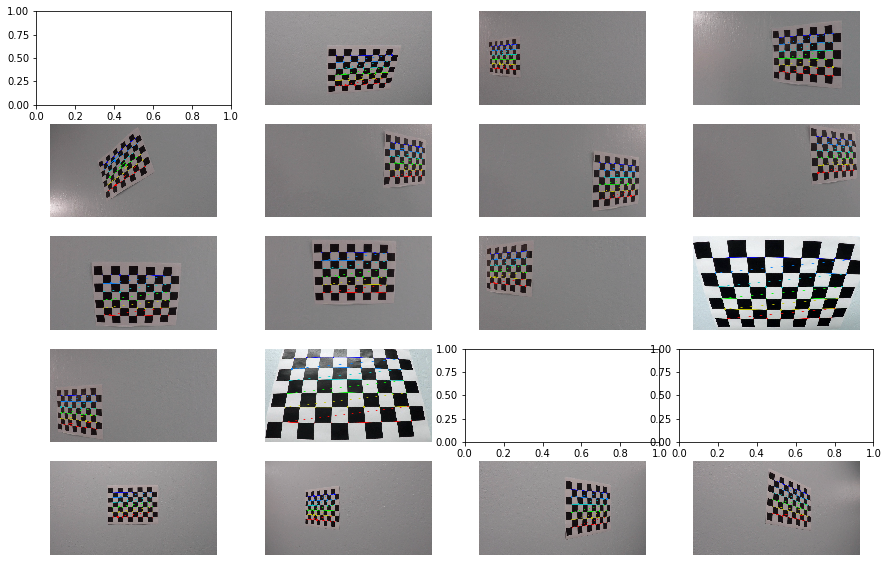

In [19]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5, 4, figsize=(15, 10))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

        axs[i].axis('off')
        axs[i].imshow(img)        
        
#cv2.destroyAllWindows()

## And so on and so forth...

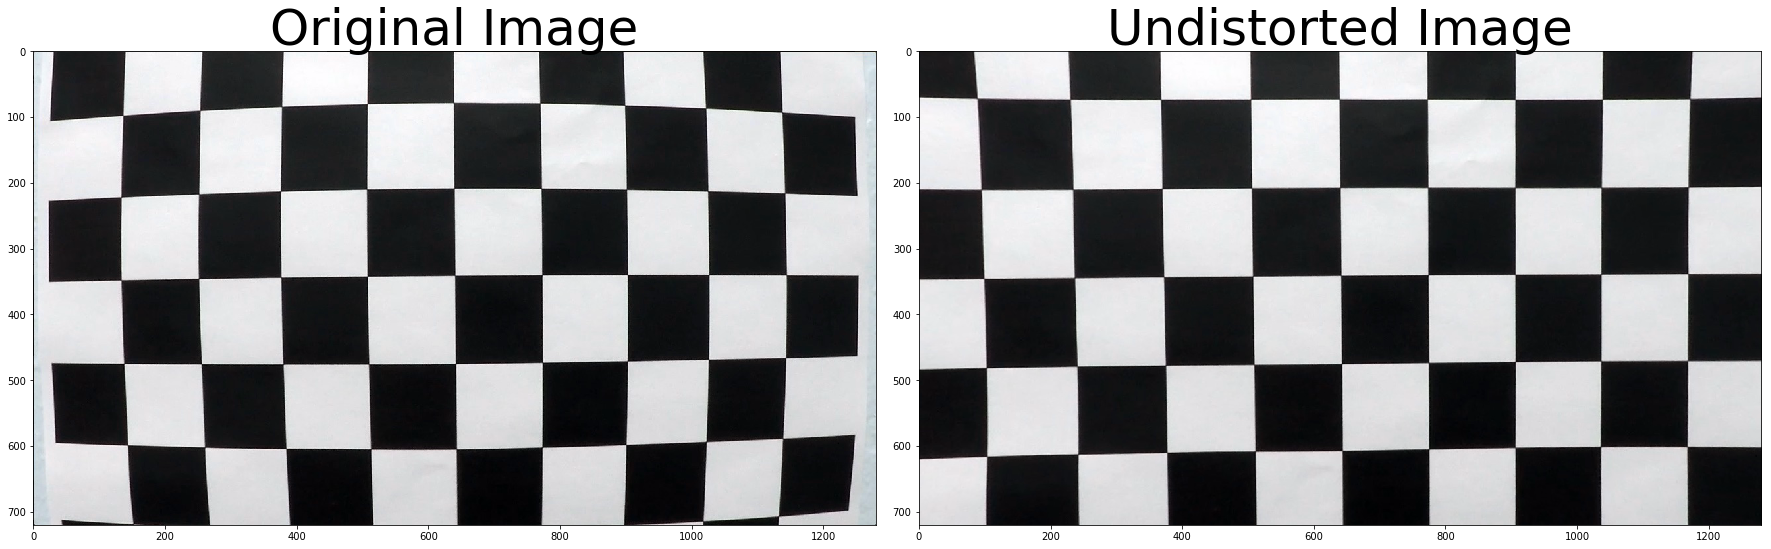

In [23]:
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Common Library

In [38]:
def plot(oimg, cimage, comment='Converted image', cmap=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(oimg, cmap=cmap)
    ax1.set_title('Original image', fontsize=20)
    ax2.imshow(cimage, cmap=cmap)
    ax2.set_title(comment, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 1. distortion-corrected image

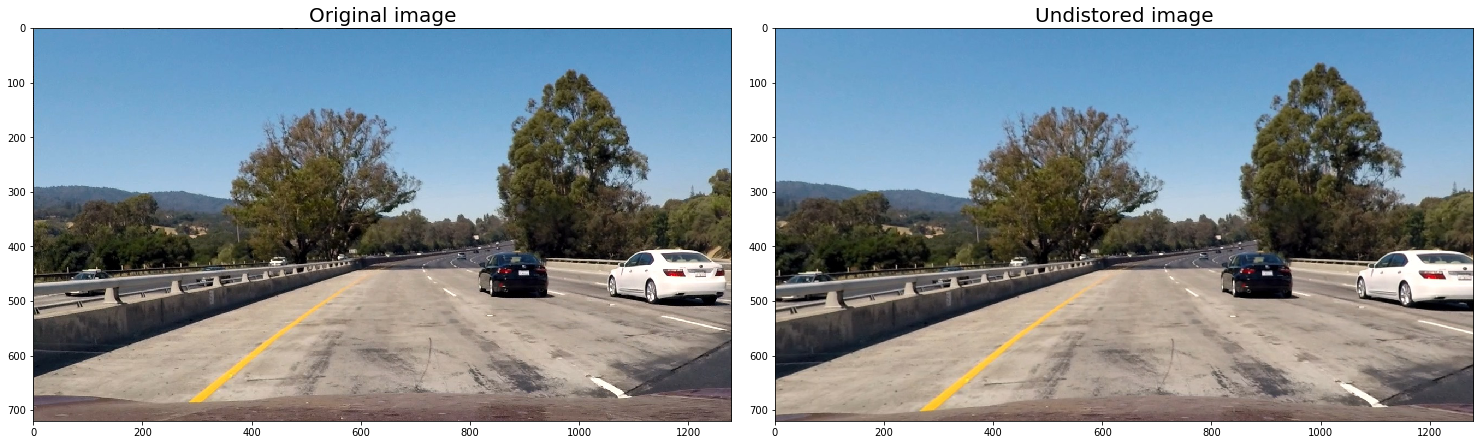

In [39]:
# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# undistort 
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

plot(img, undistorted, "Undistored image")

### 2. thresholded binary image

### 2.1 gradient threshold

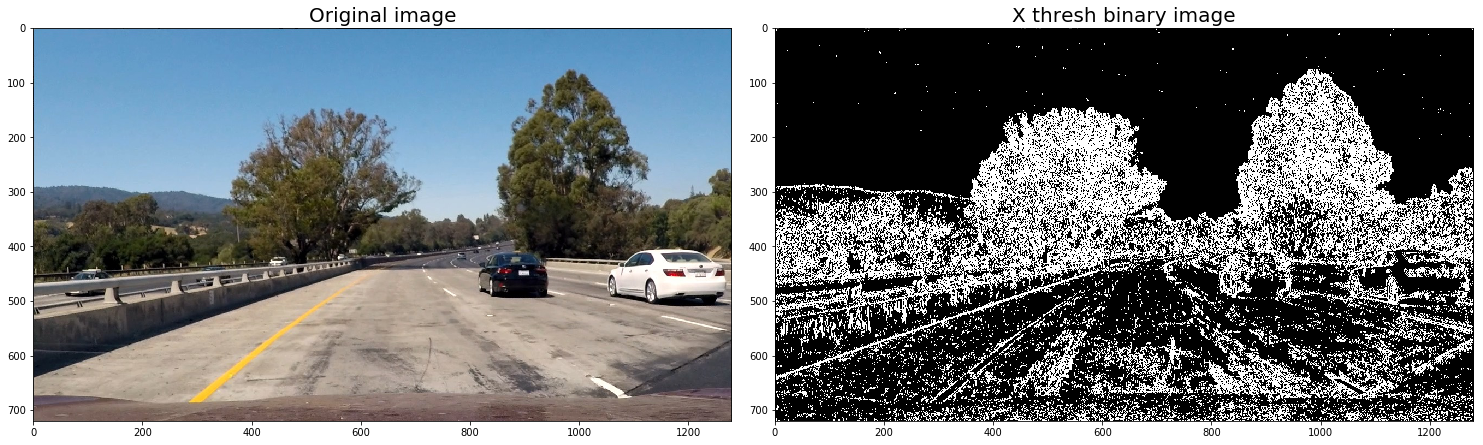

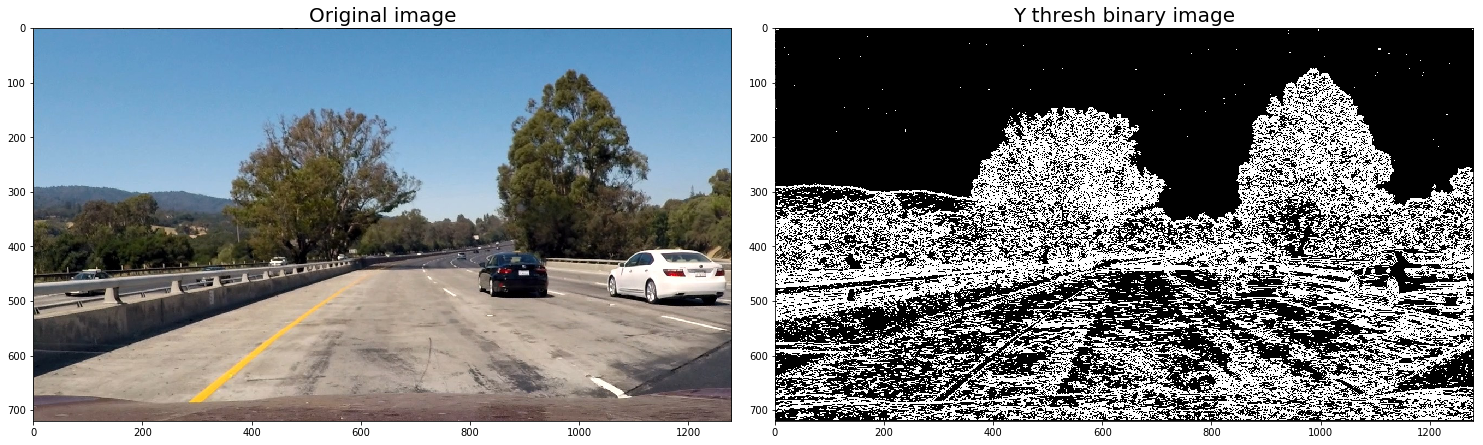

In [124]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

grad_binary = abs_sobel_thresh(img, orient='x', thresh=(5, 100))
plot(img, grad_binary, "X thresh binary image", cmap='gray')

grad_binary = abs_sobel_thresh(img, orient='y', thresh=(5, 100))
plot(img, grad_binary, "Y thresh binary image", cmap='gray')


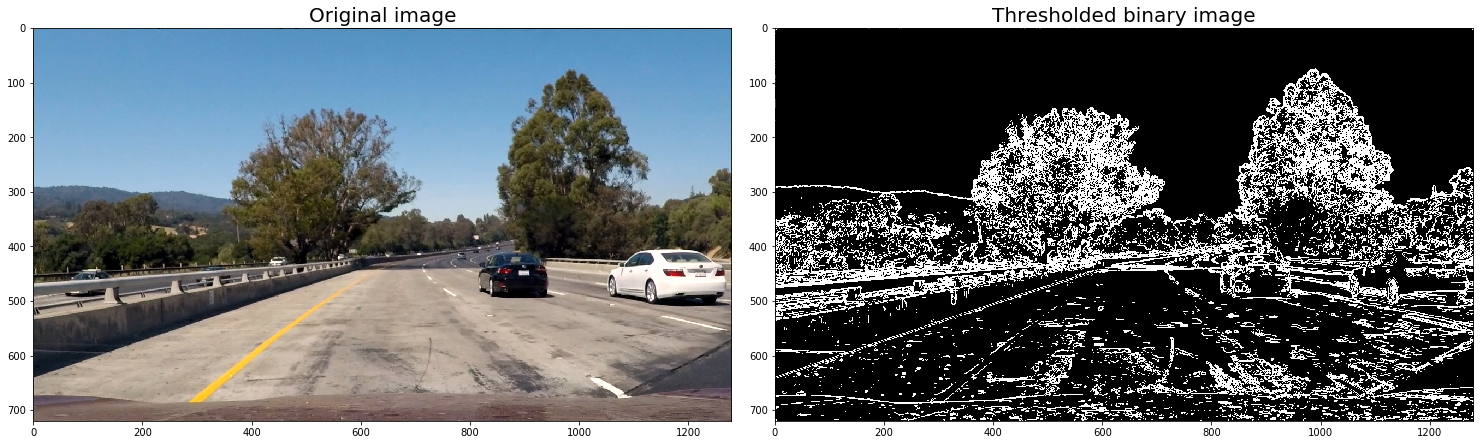

In [103]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

grad_binary = mag_thresh(img, sobel_kernel=3, thresh=(15, 100))

plot(img, grad_binary, "Thresholded binary image", cmap='gray')

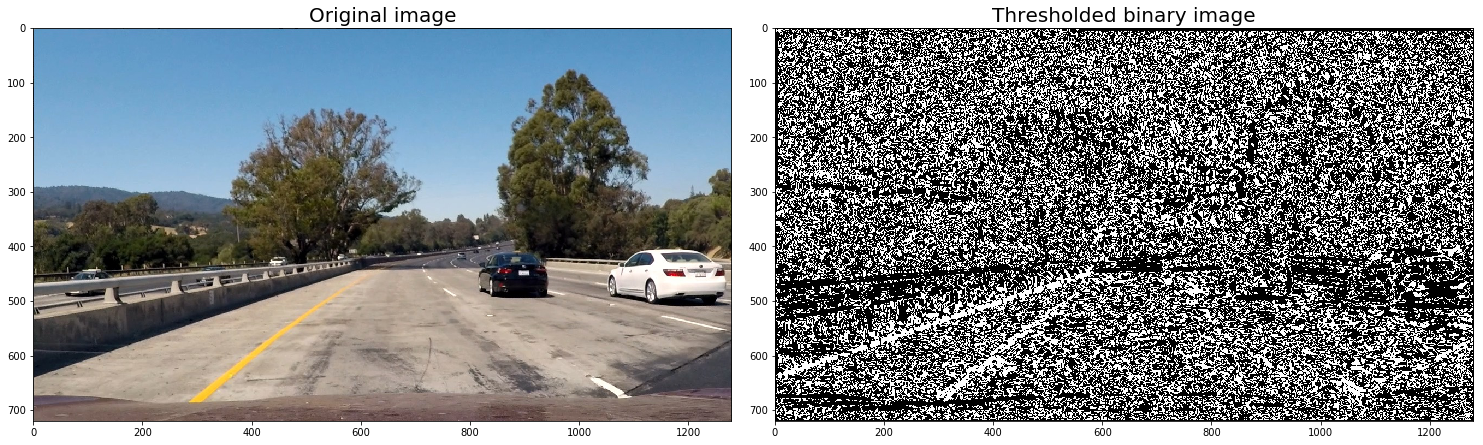

In [96]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plot(img, dir_binary, "Thresholded binary image", cmap='gray')

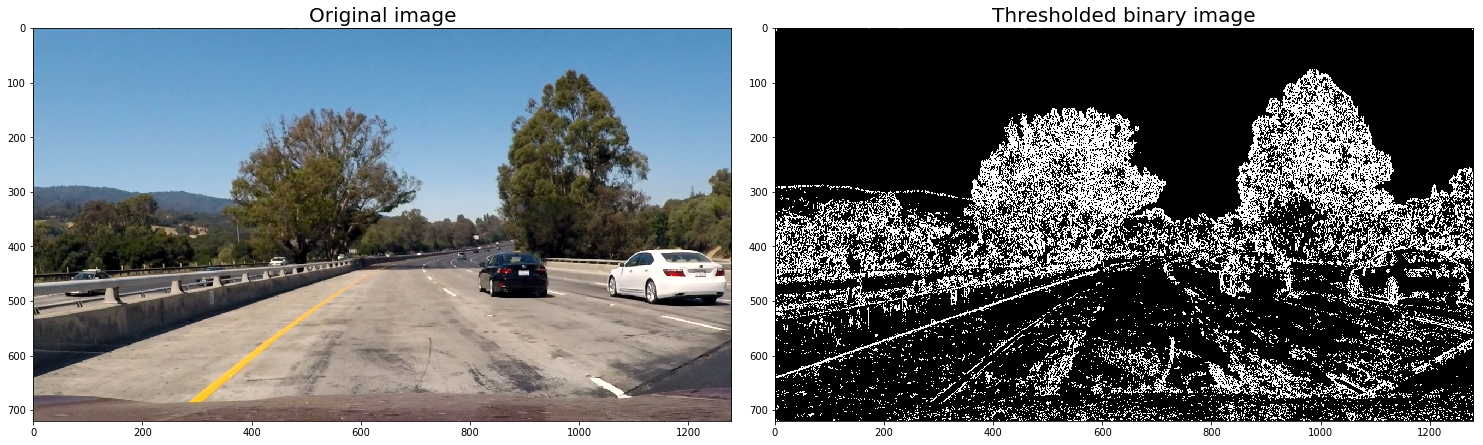

In [126]:
# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(10, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plot(img, combined, "Thresholded binary image", cmap='gray')

### 2.2 HLS color threshold

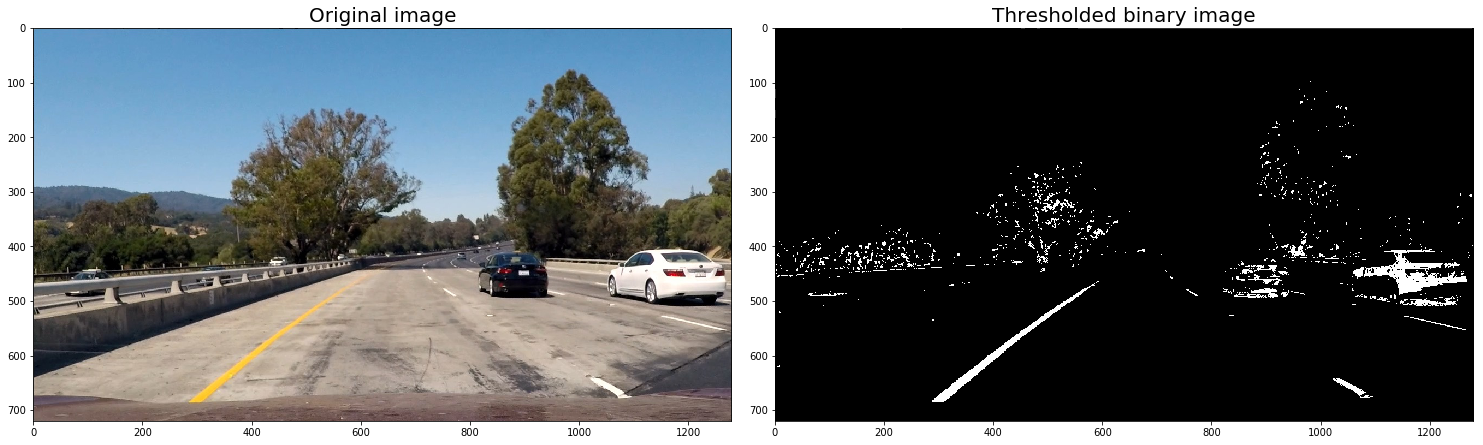

In [131]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

hls_binary = hls_select(img, thresh=(150, 255))
plot(img, hls_binary, "Thresholded binary image", cmap='gray')

### 2.3 HLS color & Gradient threshold

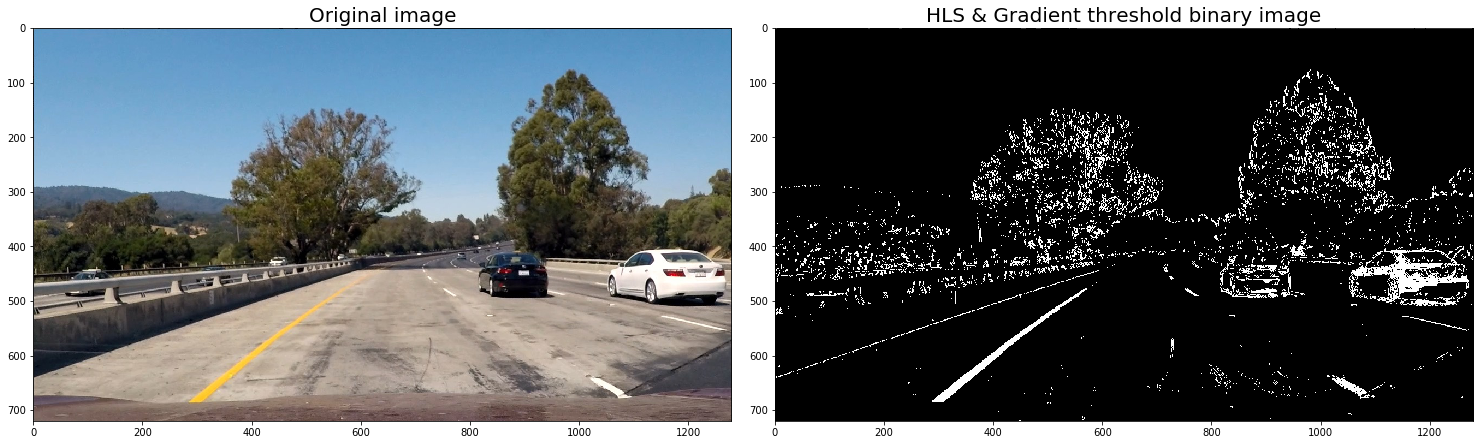

In [140]:
def pipeline(img, gx_thresh=(30, 100), hls_thresh=(170, 255), sobel_kernel=3):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= gx_thresh[0]) & (scaled_sobel <= gx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    

# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cimg = pipeline(img)
plot(img, cimg, "HLS & Gradient threshold binary image", cmap='gray')

### 3. perspective transform 

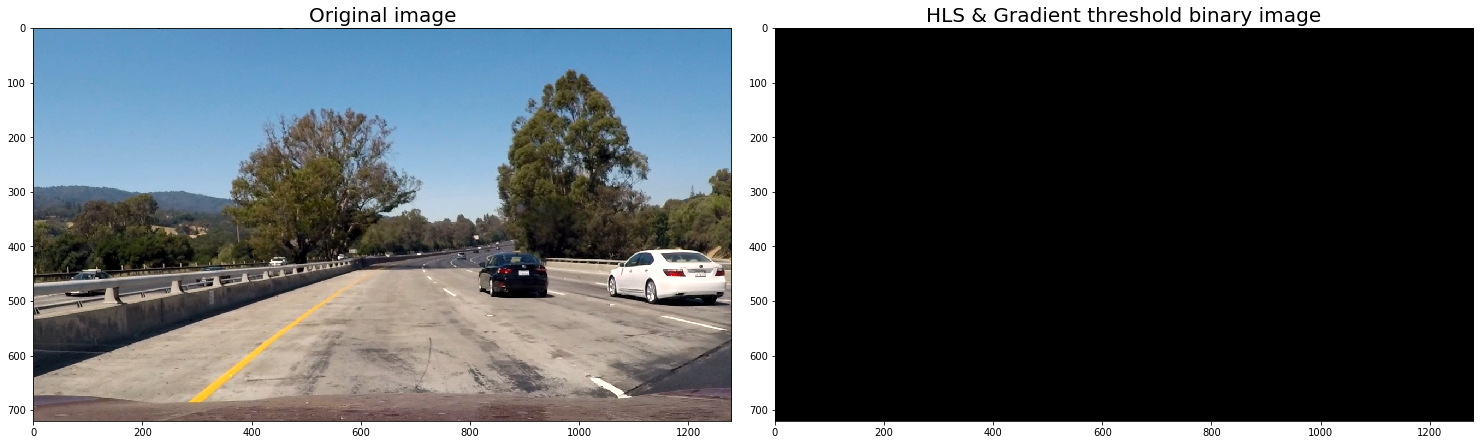

In [146]:
def unwrap(img, src, dst):
    h,w = img.shape[:2]
    img_size = [w, h]

    M  = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    wrapped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return wrapped, M, Minv

# Choose an smaple image 
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_size = img.shape[:2]    
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
cimg, M, Minv = unwrap(img, src, dst)
plot(img, cimg, "Wraped result with dest. points drawn", cmap='gray')